# Library import & Drive mount

In [ ]:
import dlib # DIP 라이브러리 (Face detection, Landmark detection, Face alignment)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Images

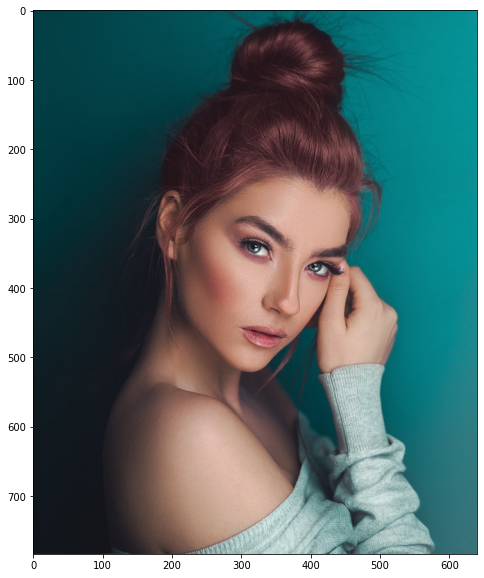

In [ ]:
img = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/01.jpg')

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Load dlib Models

In [ ]:
detector = dlib.get_frontal_face_detector() # 얼굴 영역 인식 모델 로드
sp = dlib.shape_predictor('/content/drive/MyDrive/BeautyGAN-master/models/shape_predictor_5_face_landmarks.dat') # 5점 랜드마크 모델 로드

# Face Detection

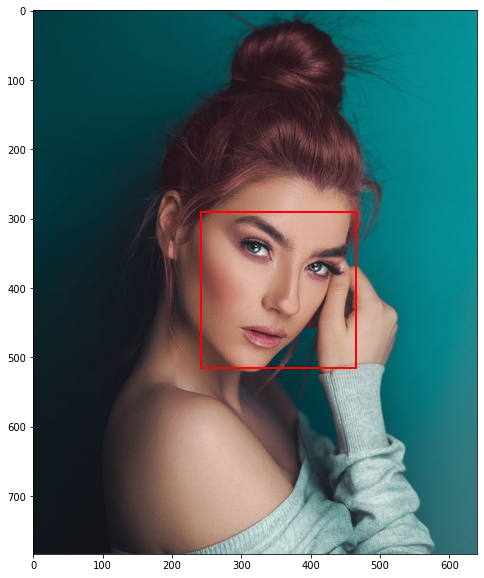

In [ ]:
img_result = img.copy()

dets = detector(img, 1) # 이미지에서 얼굴 영역 찾기

# 얼굴 영역의 개수가 0일 경우
if len(dets) == 0:
    print('cannot find faces!')

fig, ax = plt.subplots(1, figsize=(16, 10))

# 얼굴 찾으면 -> det : rectangle object
for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none') # 직사각형 그리기
    ax.add_patch(rect) # 그래프 영역에 패치 추가

ax.imshow(img_result)

# Lankmark Detection 
#### 5 points (Face Detection 한 부분에서 눈 양쪽 끝과 코 끝)

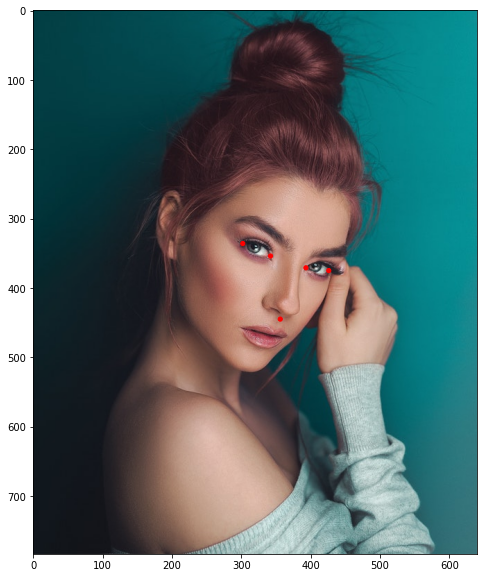

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections() # 얼굴 수평 맞춰주기 위해 사용할 인스턴스

for detection in dets:
    s = sp(img, detection) # 위에서 로드했던, 얼굴의 랜드마크 찾는 모델에 img와 rectangle 위치 넣어줌
    objs.append(s)
    
    for point in s.parts(): # 5점이니까 for문 5번 반복
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

# Align Faces
#### 5개 랜드마크를 기준으로 얼굴의 수평 맞춰주기

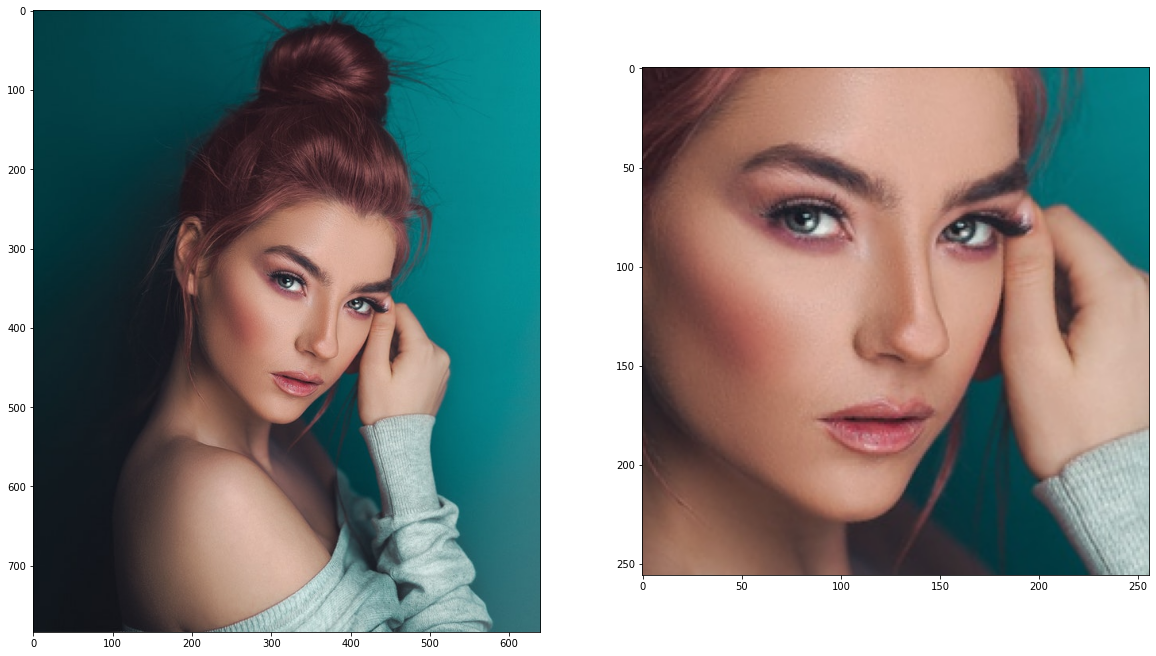

In [ ]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3) # 얼굴을 수평으로 회전해 얼굴 부분만 자른 이미지 반환, padding 작게 주면 타이트하게 자름

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))

axes[0].imshow(img)

for i, face in enumerate(faces): # detection한 얼굴이 여러개면 for문 여러번 반복
    axes[i+1].imshow(face)

# Functionalize

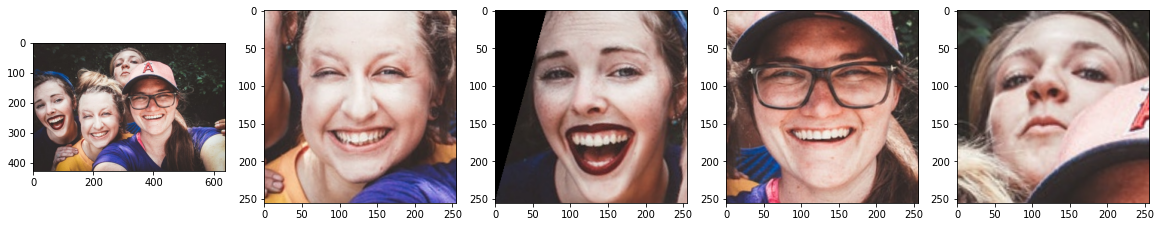

In [ ]:
# 원본 이미지 입력하면 align 된 얼굴 이미지 반환하는 함수 

def align_faces(img):
    dets = detector(img, 1)
    
    objs = dlib.full_object_detections()

    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)
    
    return faces


# test
test_img = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/02.jpg')

test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

# Load BeautyGAN Pretrained
- https://drive.google.com/drive/folders/1pgVqnF2-rnOxcUQ3SO4JwHUFTdiSe5t9

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.compat.v1.disable_eager_execution()

In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    sess = tf.compat.v1.Session()
    saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/BeautyGAN-master/models/model.meta')
    saver.restore(sess, tf.compat.v1.train.latest_checkpoint('/content/drive/MyDrive/BeautyGAN-master/models'))
    graph = tf.compat.v1.get_default_graph()

    X = graph.get_tensor_by_name('X:0') # source (no makeup img)
    Y = graph.get_tensor_by_name('Y:0') # reference (makeup img)
    Xs = graph.get_tensor_by_name('generator/xs:0') # output (generator가 만든 출력 img)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/BeautyGAN-master/models/model


# Preprocess and Postprocess Functions

In [ ]:
# uint8(0~255) -> float32(-1~1)
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

# float32(-1~1) -> uint8(0~255)
def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

# Load Images

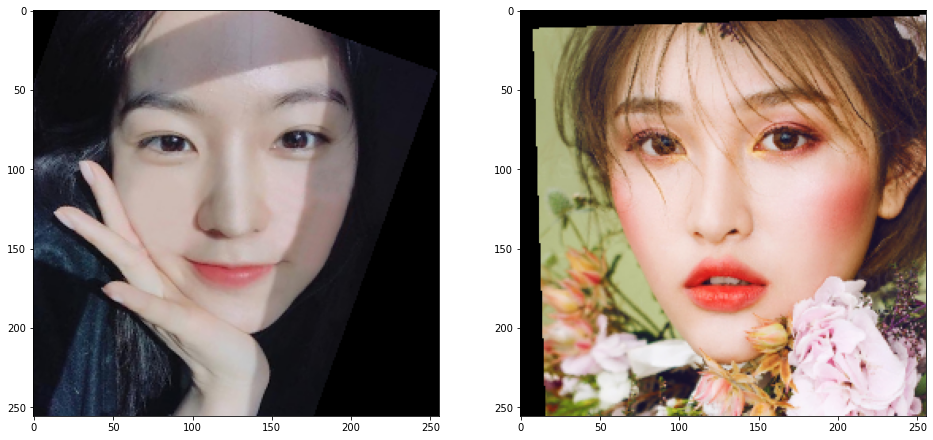

In [ ]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/11.jpg') # source (no makeup img) 
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/makeup/vFG756.png') # reference (makeup img)
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

# Run

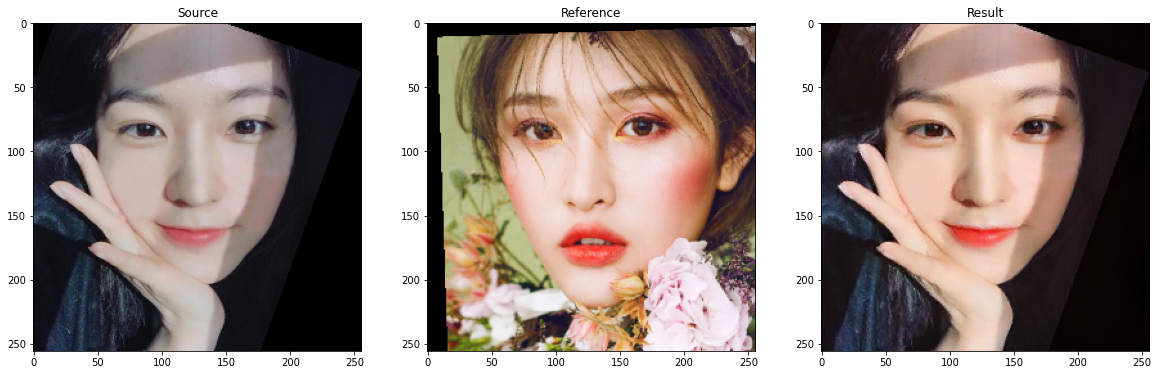

In [ ]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)              # array(256,256,3)
X_img = np.expand_dims(X_img, axis=0)    # array(1,256,256,3)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)